<a href="https://colab.research.google.com/github/Aakash3708/TechHealthAnalytics/blob/main/TechHealthAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import sqlite3 as sql
from google.colab import files
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

# Upload the dataset
uploaded = files.upload()
dataset = next(iter(uploaded.keys()))  # Get the filename of the uploaded file
con = sql.connect(dataset)


Saving mental_health.sqlite to mental_health (1).sqlite


In [12]:
# Query to get the list of tables
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(tables_query, con)
print("Tables in the database:")
print(tables)

# Query to get columns of the 'Answer' table
columns_query = "PRAGMA table_info(Answer);"
columns = pd.read_sql(columns_query, con)
print("Columns in the 'Answer' table:")
print(columns)


Tables in the database:
       name
0    Answer
1  Question
2    Survey
Columns in the 'Answer' table:
   cid        name            type  notnull dflt_value  pk
0    0  AnswerText  VARCHAR(10000)        0       None   0
1    1    SurveyID         INTEGER        0       None   0
2    2      UserID         INTEGER        0       None   0
3    3  QuestionID         INTEGER        0       None   0


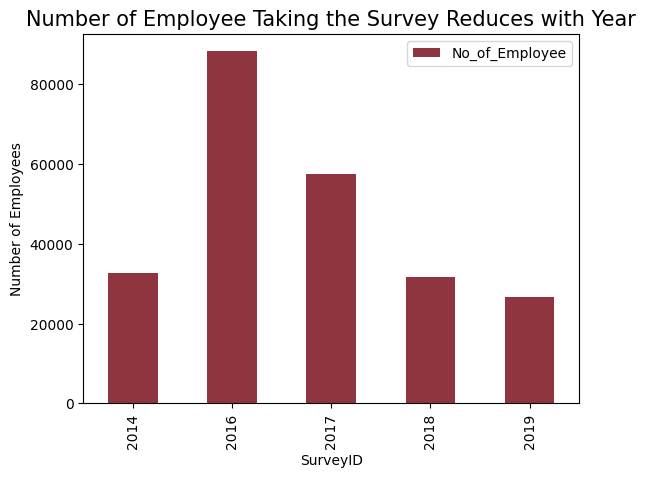

In [3]:
# Query to get the number of employees per survey
query = """
    SELECT
        SurveyID,
        COUNT() AS No_of_Employee
    FROM Answer
    GROUP BY SurveyID;
"""
Employee_per_survey = pd.read_sql(query, con).astype({"No_of_Employee": int})

# Plotting the number of employees per survey
barplot = Employee_per_survey.plot.bar(x='SurveyID', y='No_of_Employee', color='#7A111E', alpha=0.85)
plt.title('Number of Employee Taking the Survey Reduces with Year', fontsize=15)
plt.ylabel('Number of Employees')
plt.xlabel('SurveyID')
plt.show()


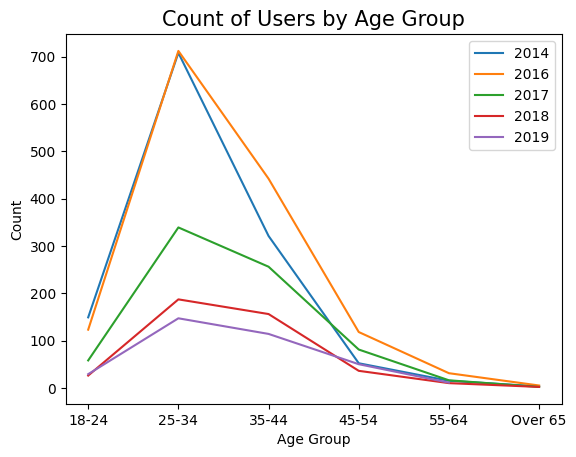

In [4]:
# Query to get age distribution per survey
query = """
SELECT SurveyID,
       CASE
            WHEN AnswerText BETWEEN 18 AND 24 THEN '18-24'
            WHEN AnswerText BETWEEN 25 AND 34 THEN '25-34'
            WHEN AnswerText BETWEEN 35 AND 44 THEN '35-44'
            WHEN AnswerText BETWEEN 45 AND 54 THEN '45-54'
            WHEN AnswerText BETWEEN 55 AND 64 THEN '55-64'
            WHEN AnswerText BETWEEN 65 AND 99 THEN 'Over 65'
        END AS age_group,
    COUNT(*) AS count
FROM Answer
WHERE SurveyID IN (2014, 2016, 2017, 2018, 2019)
      AND QuestionID = 1
      AND AnswerText > 18
GROUP BY SurveyID, age_group
ORDER BY SurveyID, age_group;
"""
Age_Survey = pd.read_sql(query, con)

# Get unique survey IDs for plotting
SurveyID_groups = Age_Survey['SurveyID'].unique()

# Create a line plot for each survey year showing age group distribution
fig, ax = plt.subplots()
for SurveyID_group in SurveyID_groups:
    ax.plot(Age_Survey.loc[Age_Survey['SurveyID'] == SurveyID_group, 'age_group'],
            Age_Survey.loc[Age_Survey['SurveyID'] == SurveyID_group, 'count'],
            label=SurveyID_group)

# Set labels and title for the age distribution plot
ax.set_xlabel('Age Group')
ax.set_ylabel('Count')
ax.set_title('Count of Users by Age Group', fontsize=15)
ax.legend()
plt.show()


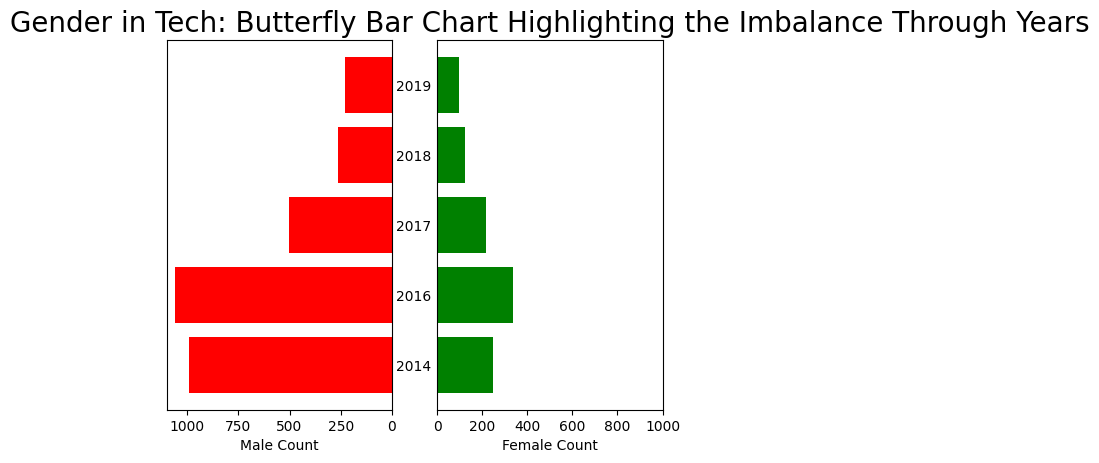

In [5]:
# Query to get gender distribution per survey
query = """
SELECT SurveyID,
       SUM(CASE WHEN AnswerText = 'male' OR AnswerText = 'Male' THEN 1 ELSE 0 END) AS male_count,
       SUM(CASE WHEN AnswerText = 'female' OR AnswerText = 'Female' THEN 1 ELSE 0 END) AS female_count
FROM Answer
WHERE QuestionID = 2
      OR (QuestionID = 9 AND AnswerText = 1)
      OR (QuestionID = 3 AND (AnswerText = 'United States of America' OR AnswerText = 'United States'))
GROUP BY SurveyID
"""
df = pd.read_sql(query, con)

# Positioning for the butterfly bar chart
position = np.arange(len(df)) + 0.5

# Create a butterfly bar chart for gender distribution
fig, (ax_left, ax_right) = plt.subplots(ncols=2)
ax_left.barh(position, df['male_count'], align='center', facecolor='red')
ax_left.set_xlim((0, 1100))
ax_left.set_yticks([])
ax_left.invert_xaxis()
ax_left.set_xlabel('Male Count')

ax_right.barh(position, df['female_count'], align='center', facecolor='green')
ax_right.set_xlim((0, 1000))
ax_right.set_yticks(position)
ax_right.set_yticklabels(df['SurveyID'].values, ha='center', x=-0.06)
ax_right.set_xlabel('Female Count')

plt.title('Gender in Tech: Butterfly Bar Chart Highlighting the Imbalance Through Years', fontsize=20)
plt.tick_params(left=False)
plt.show()


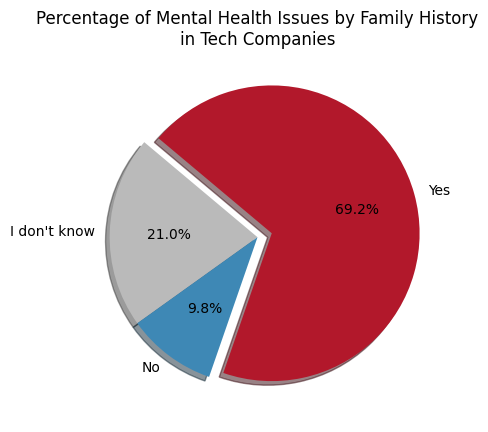

In [6]:
query = """

SELECT family_history,
       100.0 * COUNT(family_history) / SUM(COUNT(family_history)) OVER () AS percentage
FROM (
    SELECT SurveyID AS year,
            MAX(CASE WHEN (QuestionID == 4  AND AnswerText !=-1) THEN AnswerText END) AS state,
            MAX(CASE WHEN (QuestionID == 5  AND AnswerText != 1) THEN AnswerText END) AS Self_Employed,
            MAX(CASE WHEN (QuestionID == 13 AND AnswerText == 1) THEN 'Tech_company' END) AS tech_company,
            MAX(CASE WHEN (QuestionID == 33 AND AnswerText == 'Yes') THEN 1 END) AS Mental_Health,
            MAX(CASE WHEN (QuestionID == 6 ) THEN AnswerText END) AS family_history

    FROM Answer
    WHERE QuestionID IN (4,5,6, 13, 33) AND year != 2014
    GROUP BY year, UserID
    HAVING state IS NOT NULL
       AND Self_Employed IS NOT NULL
       AND tech_company IS NOT NULL
       AND Mental_Health IS NOT NULL
)
GROUP BY  family_history
"""
df = pd.read_sql(query, con)

colors = ["#BABABA", "#3E88B5", "#B2182B"]
explode = (0, 0, 0.1)
plt.pie(df["percentage"], labels=df["family_history"], explode=explode, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Percentage of Mental Health Issues by Family History\n"+"in Tech Companies")
plt.show()


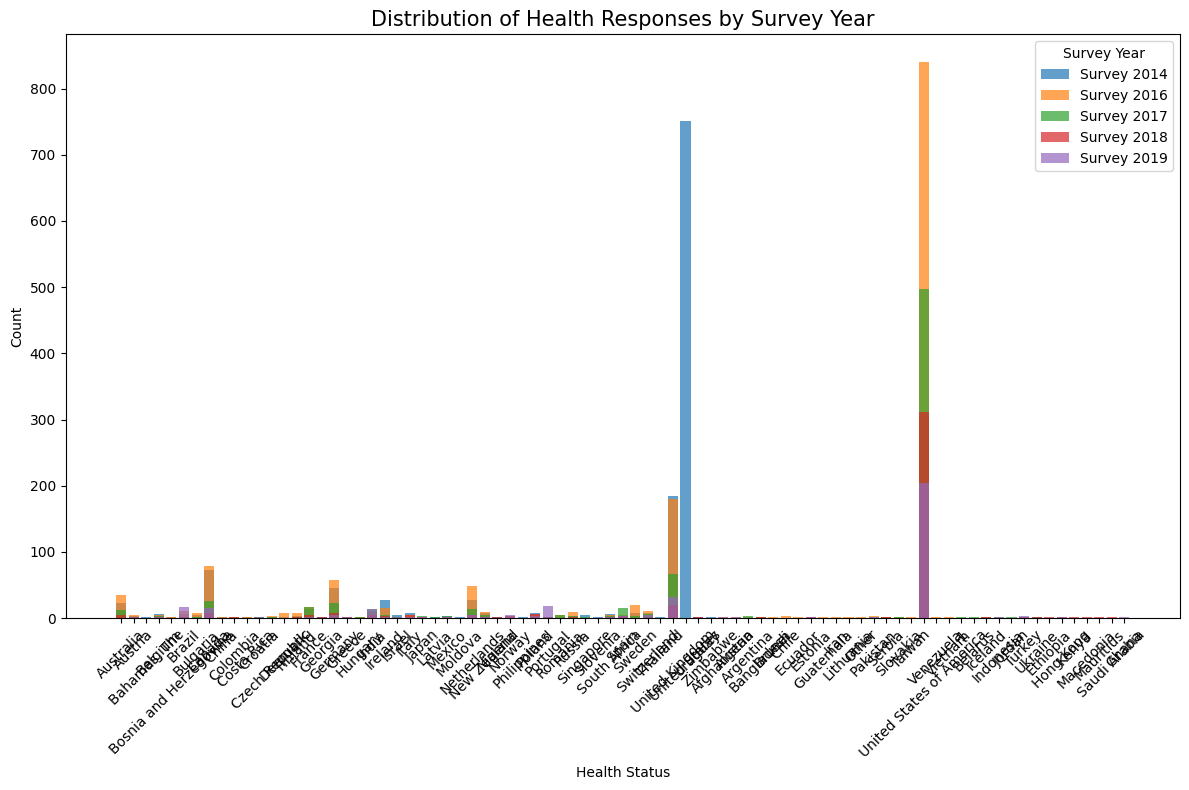

In [13]:
query = """
SELECT SurveyID,
       AnswerText AS Health_Status,
       COUNT(*) AS Count
FROM Answer
WHERE QuestionID = 3  -- Replace 3 with the actual ID for health-related questions
GROUP BY SurveyID, Health_Status
ORDER BY SurveyID, Health_Status;
"""
health_distribution = pd.read_sql(query, con)

# Plot distribution of health responses
plt.figure(figsize=(12, 8))
for survey_id in health_distribution['SurveyID'].unique():
    subset = health_distribution[health_distribution['SurveyID'] == survey_id]
    plt.bar(subset['Health_Status'], subset['Count'], label=f'Survey {survey_id}', alpha=0.7)

plt.xlabel('Health Status')
plt.ylabel('Count')
plt.title('Distribution of Health Responses by Survey Year', fontsize=15)
plt.legend(title='Survey Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


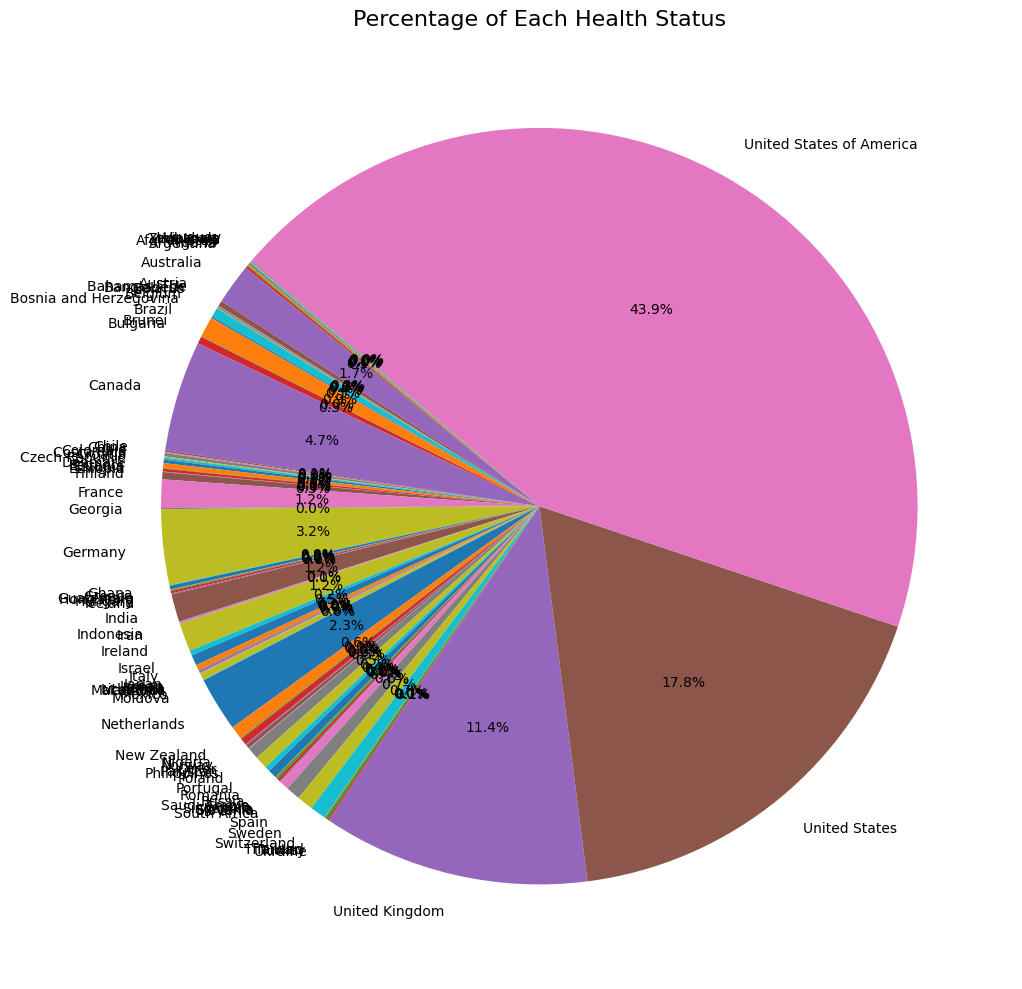

In [21]:
query = """
SELECT AnswerText AS Health_Status,
       COUNT(*) AS Count
FROM Answer
WHERE QuestionID = 3  -- Replace with the actual ID for health-related questions
GROUP BY Health_Status;
"""
health_percentage = pd.read_sql(query, con)
total_count = health_percentage['Count'].sum()
health_percentage['Percentage'] = (health_percentage['Count'] / total_count) * 100

# Plot percentage of responses for each health status
plt.figure(figsize=(14, 10))  # Increase figure size
plt.pie(health_percentage['Percentage'], labels=health_percentage['Health_Status'], autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})  # Adjust font size
plt.title('Percentage of Each Health Status', fontsize=16)
plt.tight_layout()
plt.show()



In [23]:
import pandas as pd
import plotly.graph_objs as go

# Execute the SQL query and load data into a DataFrame
query = """
SELECT year, company_type,
       COUNT(Mental_Health) AS total_Mental_Health,
       SUM(Mental_Health) AS have_Mental_Health,
       100.0*SUM(Mental_Health)/COUNT(Mental_Health) AS Percentage
FROM (
    SELECT SurveyID AS year,
           MAX(CASE WHEN (QuestionID = 4 AND AnswerText != -1) THEN AnswerText END) AS state,
           MAX(CASE WHEN (QuestionID = 5 AND AnswerText != 1) THEN AnswerText END) AS Self_Employed,
           MAX(CASE WHEN (QuestionID = 13 AND AnswerText = 1) THEN 'Tech_company' ELSE 'Other_company' END) AS company_type,
           MAX(CASE WHEN (QuestionID = 33 AND AnswerText = 'Yes') THEN 1 ELSE 0 END) AS Mental_Health
    FROM Answer
    WHERE QuestionID IN (4, 5, 13, 33) AND SurveyID != 2014
    GROUP BY year, UserID
    HAVING state IS NOT NULL
       AND Self_Employed IS NOT NULL
) AS mh_data
GROUP BY year, company_type;
"""

df = pd.read_sql(query, con)

# Create traces for the bar chart
trace1 = go.Bar(
    x=df[df['company_type'] == 'Other_company']['year'],
    y=df[df['company_type'] == 'Other_company']['total_Mental_Health'],
    name='Other Company - Total Count',
    marker_color='#D6604D'
)

trace2 = go.Bar(
    x=df[df['company_type'] == 'Tech_company']['year'],
    y=df[df['company_type'] == 'Tech_company']['total_Mental_Health'],
    name='Tech Company - Total Count',
    marker_color='#4393C3'
)

# Define the layout for the bar chart
layout_bar = go.Layout(
    title='Total Number of Employees with Mental Health Issues by Company Type',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Total Number of Employees'),
    barmode='group',
    legend=dict(x=0.8, y=1.1, orientation='h')
)

# Create the figure and show the bar chart
fig_bar = go.Figure(data=[trace1, trace2], layout=layout_bar)
fig_bar.show()


In [24]:
import pandas as pd
import plotly.graph_objs as go

# Execute the SQL query and load data into a DataFrame
query = """
SELECT year, company_type,
       COUNT(Mental_Health) AS total_Mental_Health,
       SUM(Mental_Health) AS have_Mental_Health,
       100.0*SUM(Mental_Health)/COUNT(Mental_Health) AS Percentage
FROM (
    SELECT SurveyID AS year,
           MAX(CASE WHEN (QuestionID = 4 AND AnswerText != -1) THEN AnswerText END) AS state,
           MAX(CASE WHEN (QuestionID = 5 AND AnswerText != 1) THEN AnswerText END) AS Self_Employed,
           MAX(CASE WHEN (QuestionID = 13 AND AnswerText = 1) THEN 'Tech_company' ELSE 'Other_company' END) AS company_type,
           MAX(CASE WHEN (QuestionID = 33 AND AnswerText = 'Yes') THEN 1 ELSE 0 END) AS Mental_Health
    FROM Answer
    WHERE QuestionID IN (4, 5, 13, 33) AND SurveyID != 2014
    GROUP BY year, UserID
    HAVING state IS NOT NULL
       AND Self_Employed IS NOT NULL
) AS mh_data
GROUP BY year, company_type;
"""

df = pd.read_sql(query, con)

# Create traces for the line chart
trace3 = go.Scatter(
    x=df[df['company_type'] == 'Other_company']['year'],
    y=df[df['company_type'] == 'Other_company']['Percentage'],
    name='Other Company - Percentage',
    yaxis='y2',
    marker_color='#B2182B',
    mode='lines+markers'
)

trace4 = go.Scatter(
    x=df[df['company_type'] == 'Tech_company']['year'],
    y=df[df['company_type'] == 'Tech_company']['Percentage'],
    name='Tech Company - Percentage',
    yaxis='y2',
    marker_color='#2166AC',
    mode='lines+markers'
)

# Define the layout for the line chart
layout_line = go.Layout(
    title='Percentage of Employees with Mental Health Issues by Company Type',
    xaxis=dict(title='Year'),
    yaxis2=dict(
        title='Percentage of Users with Mental Health',
        overlaying='y',
        side='right',
        range=[0, 100]
    ),
    legend=dict(x=0.8, y=1.1, orientation='h')
)

# Create the figure and show the line chart
fig_line = go.Figure(data=[trace3, trace4], layout=layout_line)
fig_line.show()
